In [68]:
import os
import pickle
import pandas as pd
import numpy as np
import sklearn
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    MinMaxScaler,
    PowerTransformer,
    FunctionTransformer,
    StandardScaler,
    OrdinalEncoder
)
from sklearn.compose import ColumnTransformer
from feature_engine.outliers import Winsorizer
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
)
from feature_engine.datetime import DatetimeFeatures
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import metrics
import seaborn as sns

### Display Settings

In [2]:
pd.set_option('display.max_columns',None)

In [3]:
sklearn.set_config(transform_output='pandas')

In [4]:
warnings.filterwarnings('ignore')

### Read Datasets

In [5]:
train = pd.read_csv('train.csv')

test = pd.read_csv('test.csv')

validation = pd.read_csv('val.csv')

### 4. Preprocessing Operations

In [6]:
# airline
air_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

#doj
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
    ("scaler", MinMaxScaler())
])

# source & destination
location_pipe1 = Pipeline(steps=[
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
    ("encoder", MeanEncoder()),
    ("scaler", PowerTransformer())
])

def is_north(X):
    columns = X.columns.to_list()
    north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
    return (
        X
        .assign(**{
            f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )

location_transformer = FeatureUnion(transformer_list=[
    ("part1", location_pipe1),
    ("part2", FunctionTransformer(func=is_north))
])

# dep_time & arrival_time
time_pipe1 = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
    ("scaler", MinMaxScaler())
])

def part_of_day(X, morning=4, noon=12, eve=16, night=20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col: pd.to_datetime(X.loc[:, col]).dt.hour
        for col in columns
    })

    return (
        X_temp
        .assign(**{
            f"{col}_part_of_day": np.select(
                [X_temp.loc[:, col].between(morning, noon, inclusive="left"),
                 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
                 X_temp.loc[:, col].between(eve, night, inclusive="left")],
                ["morning", "afternoon", "evening"],
                default="night"
            )
            for col in columns
        })
        .drop(columns=columns)
    )

time_pipe2 = Pipeline(steps=[
    ("part", FunctionTransformer(func=part_of_day)),
    ("encoder", CountFrequencyEncoder()),
    ("scaler", MinMaxScaler())
])

time_transformer = FeatureUnion(transformer_list=[
    ("part1", time_pipe1),
    ("part2", time_pipe2)
])

# duration
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
        self.variables = variables
        self.percentiles = percentiles
        self.gamma = gamma


    def fit(self, X, y=None):
        if not self.variables:
            self.variables = X.select_dtypes(include="number").columns.to_list()

        self.reference_values_ = {
            col: (
                X
                .loc[:, col]
                .quantile(self.percentiles)
                .values
                .reshape(-1, 1)
            )
            for col in self.variables
        }

        return self


    def transform(self, X):
        objects = []
        for col in self.variables:
            columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
            obj = pd.DataFrame(
                data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
                columns=columns
            )
            objects.append(obj)
        return pd.concat(objects, axis=1)
    

def duration_category(X, short=180, med=400):
    return (
        X
        .assign(duration_cat=np.select([X.duration.lt(short),
                                    X.duration.between(short, med, inclusive="left")],
                                    ["short", "medium"],
                                    default="long"))
        .drop(columns="duration")
    )

def is_over(X, value=1000):
    return (
        X
        .assign(**{
            f"duration_over_{value}": X.duration.ge(value).astype(int)
        })
        .drop(columns="duration")
    )

duration_pipe1 = Pipeline(steps=[
    ("rbf", RBFPercentileSimilarity()),
    ("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
    ("cat", FunctionTransformer(func=duration_category)),
    ("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
    ("part1", duration_pipe1),
    ("part2", duration_pipe2),
    ("part3", FunctionTransformer(func=is_over)),
    ("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
    ("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
    ("imputer", SimpleImputer(strategy="median")),
    ("union", duration_union)
])

# total_stops
def is_direct(X):
    return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("", FunctionTransformer(func=is_direct))
])

# additional_info
info_pipe1 = Pipeline(steps=[
    ("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

def have_info(X):
    return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

info_union = FeatureUnion(transformer_list=[
("part1", info_pipe1),
("part2", FunctionTransformer(func=have_info))
])

info_transformer = Pipeline(steps=[
("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
("union", info_union)
])

# column transformer
column_transformer = ColumnTransformer(transformers=[
("air", air_transformer, ["airline"]),
("doj", doj_transformer, ["date_of_journey"]),
("location", location_transformer, ["source", 'destination']),
("time", time_transformer, ["dep_time", "arrival_time"]),
("dur", duration_transformer, ["duration"]),
("stops", total_stops_transformer, ["total_stops"]),
("info", info_transformer, ["additional_info"])
], remainder="passthrough")

# feature selector
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
estimator=estimator,
scoring="r2",
threshold=0.1
) 

# preprocessor
preprocessor = Pipeline(steps=[
("ct", column_transformer),
("selector", selector)
])

In [7]:
preprocessor.fit(
    train.drop(columns="price"),
    train.price.copy()
)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('air',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('grouper',
                                                                   RareLabelEncoder(n_categories=2,
                                                                                    replace_with='Other',
                                                                                    tol=0.1)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline']),
                                                 ('doj',
                                                  Pipeline(steps=[('dt',
                                                                   Datetime...
                                                                                                                                     replace_with='Other',
                                                                                                                                     tol=0.1)),
                                                                                                                   ('encoder',
                                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                                  sparse_output=False))])),
                                                                                                  ('part2',
                                                                                                   FunctionTransformer(func=<function have_info at 0x000001CA07B14FE0>))]))]),
                                                  ['additional_info'])])),
                ('selector',
                 SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(max_depth=3,
                                                                                  n_estimators=10,
                                                                                  random_state=42),
                                                  scoring='r2',
                                                  threshold=0.1))])

In [8]:
preprocessor.transform(train.drop(columns='price'))

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,1.0,0.0,0.176471,0.169492,-0.857930,-0.736484,-0.364262,2.0,0,-0.033916,1.0,0
1,0.0,1.0,0.0,0.235294,0.220339,1.065418,1.061694,-0.364262,2.0,0,0.046422,1.0,0
2,0.0,0.0,1.0,0.058824,0.067797,-0.857930,-0.736484,2.373008,0.0,0,-0.917631,0.0,1
3,0.0,0.0,0.0,0.882353,0.872881,-0.203928,-0.224351,-0.364262,2.0,0,-0.174507,1.0,0
4,0.0,1.0,0.0,0.117647,0.093220,-0.857930,-0.736484,-0.364262,2.0,0,-0.214676,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,0.0,1.0,0.0,0.176471,0.169492,1.065418,1.061694,-0.364262,2.0,1,2.597145,2.0,0
6691,0.0,0.0,0.0,0.529412,0.516949,-0.203928,-0.224351,-0.364262,2.0,0,-0.174507,1.0,0
6692,0.0,1.0,0.0,0.764706,0.779661,1.065418,1.061694,-0.364262,1.0,0,-0.666576,1.0,0
6693,0.0,0.0,1.0,1.000000,0.974576,1.065418,1.061694,-0.364262,1.0,0,-0.606322,1.0,0


### 5. Preprocess Data and save the file

In [9]:
file_name = 'E:\Machine Learning\Projects\Flight Price Prediction'

data_prefix = 'data'

In [10]:
def get_file_name(name):
    return f"{name}-pre.csv"

In [11]:
def export_data(data,name,pre):
    # split data into X and Y subsets
    X = data.drop(columns="price")
    y = data.price.copy()

    # transformation
    X_pre = pre.transform(X)

    # exporting
    file_name = get_file_name(name)
    (
        y
        .to_frame()
        .join(X_pre)
        .to_csv(file_name,index=False,header=True)
    )

In [12]:
def upload_to_file(name):
    file_name = get_file_name(name)
    os.path.join(data_prefix,f"{name}/{name}.csv")
    return file_name

In [13]:
def export_and_upload_file(data,name,pre):
    export_data(data,name,pre)
    upload_to_file(name)

In [14]:
export_and_upload_file(train,'train',preprocessor)

In [15]:
export_and_upload_file(validation,'val',preprocessor)

In [16]:
export_and_upload_file(test,'test',preprocessor)

In [17]:
train_pre = pd.read_csv('train-pre.csv')

In [18]:
train_pre.head()

,price,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,7832,0.0,1.0,0.0,0.176471,0.169492,-0.857930,-0.736484,-0.364262,2.0,0,-0.033916,1.0,0
1,6540,0.0,1.0,0.0,0.235294,0.220339,1.065418,1.061694,-0.364262,2.0,0,0.046422,1.0,0
2,7305,0.0,0.0,1.0,0.058824,0.067797,-0.857930,-0.736484,2.373008,0.0,0,-0.917631,0.0,1
3,8366,0.0,0.0,0.0,0.882353,0.872881,-0.203928,-0.224351,-0.364262,2.0,0,-0.174507,1.0,0
4,11087,0.0,1.0,0.0,0.117647,0.093220,-0.857930,-0.736484,-0.364262,2.0,0,-0.214676,1.0,0


In [23]:
test_pre = pd.read_csv('test-pre.csv')

In [24]:
val_pre = pd.read_csv('val-pre.csv')

In [22]:
X_train = train_pre.drop(columns='price')
y_train = train_pre.price.copy()

In [25]:
X_test = test_pre.drop(columns='price')
y_test = test_pre.price.copy()

In [26]:
X_val = val_pre.drop(columns='price')
y_val = val_pre.price.copy()

### Model and HyperParameter Tuning Set-Up

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR

In [21]:
lr = LinearRegression()
dtr = DecisionTreeRegressor()
rtr = RandomForestRegressor()
adr = AdaBoostRegressor()
svr = SVR()

In [35]:
lr.fit(X_train,y_train)

LinearRegression()

In [36]:
dtr.fit(X_train,y_train)


DecisionTreeRegressor()

In [37]:
rtr.fit(X_train,y_train)


RandomForestRegressor()

In [38]:
adr.fit(X_train,y_train)


AdaBoostRegressor()

In [39]:
svr.fit(X_train,y_train)

SVR()

In [40]:
y_pred_lr = lr.predict(X_test)

In [43]:
print(lr.score(X_test,y_test))
print(lr.score(X_val,y_val))

0.5290920453454987
0.5082184283301789


In [44]:
y_pred_dtr = dtr.predict(X_test)

In [45]:
print(dtr.score(X_test,y_test))
print(dtr.score(X_val,y_val))

0.5559800487035909
0.5751789825576019


In [46]:
y_pred_rtr = rtr.predict(X_test)

In [47]:
print(rtr.score(X_test,y_test))
print(rtr.score(X_val,y_val))

0.6847940405293849
0.6883923737270475


In [48]:
y_pred_adr = adr.predict(X_test)

In [49]:
print(adr.score(X_test,y_test))
print(adr.score(X_val,y_val))

0.5798192591156444
0.5577023712943858


In [50]:
y_pred_svr = svr.predict(X_test)

In [52]:
print(svr.score(X_test,y_test))
print(svr.score(X_val,y_val))

0.13118673842042639
0.10119068313993895


<Axes: xlabel='price', ylabel='Density'>

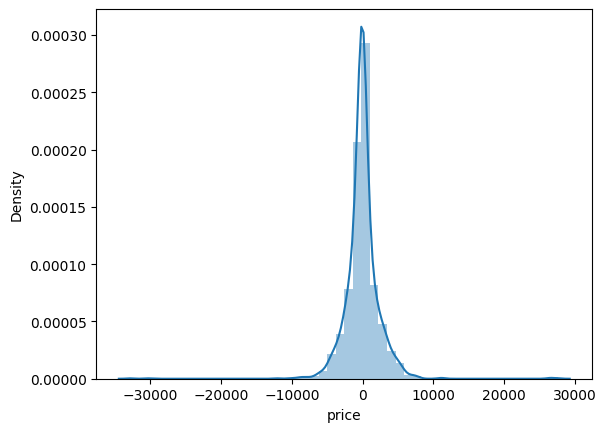

In [54]:
sns.distplot(y_test-y_pred_rtr)

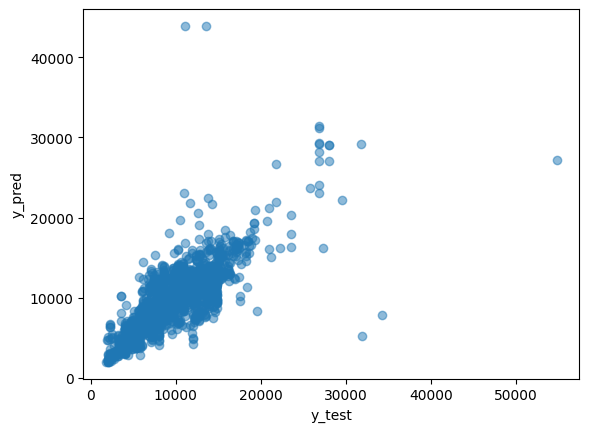

In [56]:
plt.scatter(y_test,y_pred_rtr,alpha=0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

### Hyperparamete Tuning

In [57]:
from sklearn.model_selection import RandomizedSearchCV

In [58]:
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [59]:
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [61]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = rtr,param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [62]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   2.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   2.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   2.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   2.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   2.2s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   3.0s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   3.0s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [63]:
rf_random.best_params_

{'n_estimators': 300,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 15}

In [64]:
{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}
prediction = rf_random.predict(X_test)

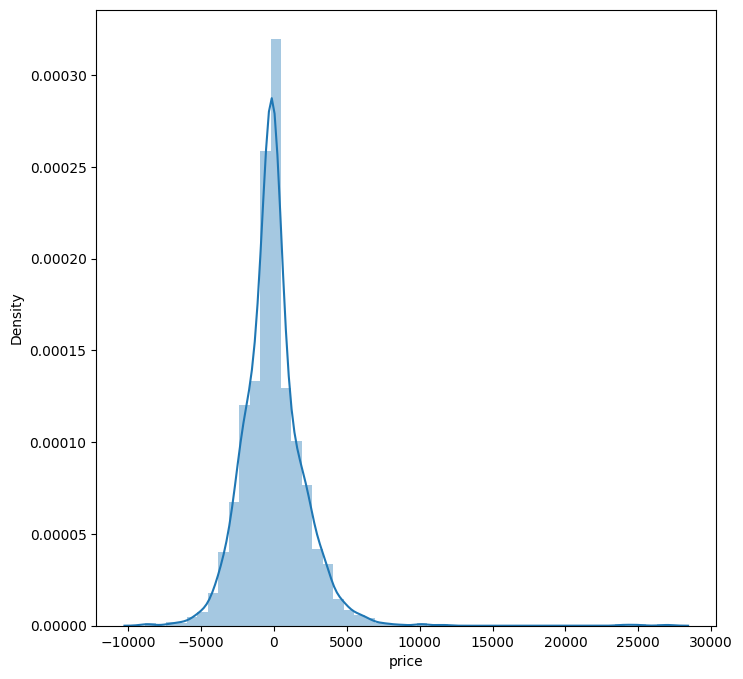

In [65]:
plt.figure(figsize = (8,8))
sns.distplot(y_test-prediction)
plt.show()

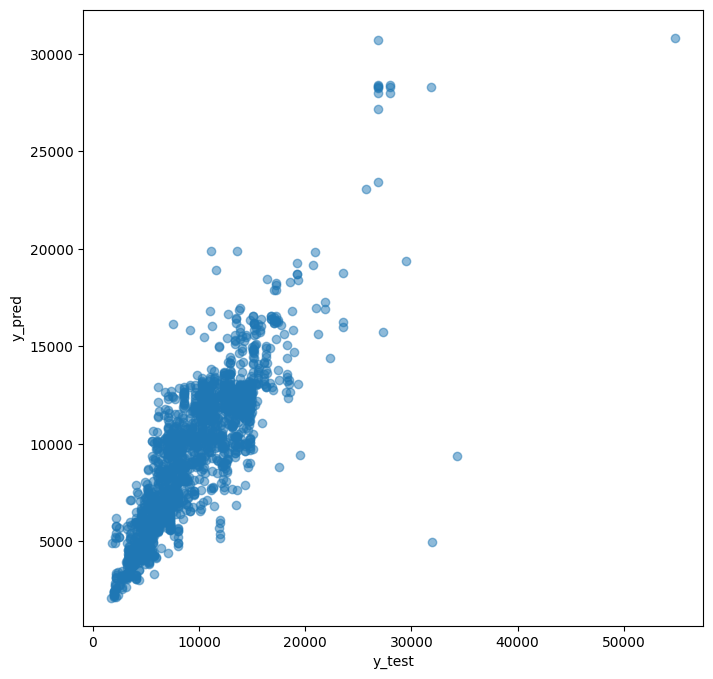

In [66]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [69]:
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 1459.3692840522187
MSE: 4836153.6962052
RMSE: 2199.1256663058616


## Save the model

In [71]:
file = open('flight_price.pkl','wb')

pickle.dump(rtr,file)

In [72]:
model = open('flight_price.pkl','rb')
forest = pickle.load(model)

In [73]:
y_prediction = forest.predict(X_test)

In [74]:
metrics.r2_score(y_test,y_prediction)

0.6847940405293849